# Executive Summary 
Build a classifier to predict whether or not a passenger survived the Titanic incident based on age, sex, passenger class, where they embarked. 

In [1]:
import os 
import pandas as pd 
import numpy as np 
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Load Data

In [2]:
TITANIC_PATH = os.path.join("data", "raw")

In [3]:
def load_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [4]:
train_data = load_data("train.csv")
test_data = load_data("test.csv")

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

## Examine missing data 


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Age and cabin appear to be the categories missing the most values. We can replace the missing values in **Age** with the median values. 

Next we'll examine numerical data: 

In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Looking at the Survived column only 38% of people survived. 
- The average age was 29 
- The average fare was 32. 

## Examine categorical values 

In [8]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [9]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [10]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

In [11]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

## Transform data

### Build pipeline for numerical data

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
num_attribs = ["Age", "SibSp", "Parch", "Fare"]

num_pipeline = Pipeline([ ("imputer", SimpleImputer(strategy="median")) ])

In [13]:
num_pipeline.fit_transform(train_data[num_attribs])

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

### Build pipeline for categorical data 

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

# Inspired from stackoverflow.com/questions/25239958
# returns the most frequent item for each selected column 
# fills any nulls with most frequent item 
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [15]:
from sklearn.preprocessing import OneHotEncoder

In [16]:
cat_attribs = ["Pclass", "Sex", "Embarked"]
cat_pipeline = Pipeline([
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [17]:
cat_pipeline.fit_transform(train_data[cat_attribs])

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

### Joining numerical to categorical data 

In [18]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train = full_pipeline.fit_transform(train_data)

In [19]:
# retrieve attribute names 
cat_attribs= list(full_pipeline.transformers_[1][1].named_steps["cat_encoder"].get_feature_names())
cat_attribs

['x0_1', 'x0_2', 'x0_3', 'x1_female', 'x1_male', 'x2_C', 'x2_Q', 'x2_S']

In [20]:
# isolating the training labels
y_train = train_data["Survived"]

# Train models 

## SVC

In [21]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
X_test = full_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

## Using cross validation we can see how well our model is doing 

In [23]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7365250822835092

Ok score, but we can probably do better. 

## Random Forest Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8149526160481217

## Visualize models 
Let's plot all 10 scores for each classifier

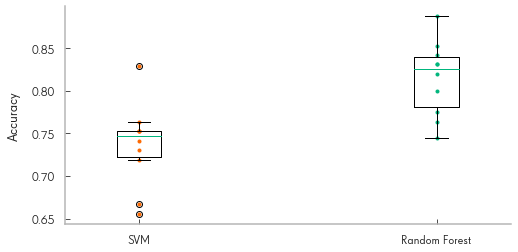

In [25]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.xlim(.75,2.25)
#plt.ylim(.5,1)
plt.show()

# Creating new features 

In [26]:
# try binning Age into AgeBucket 
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


## add agebucket feature into pipeline 
- adding agebucket as category only produced a score of .812, slightly below the previous result 
- adding AgeBucket as numerical column into pipeline yielded .813 score, again lower than previous 

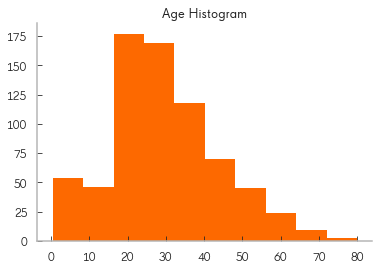

In [28]:
# visualize Age and AgeBucket histograms 
train_data['Age'].hist()
plt.title('Age Histogram');

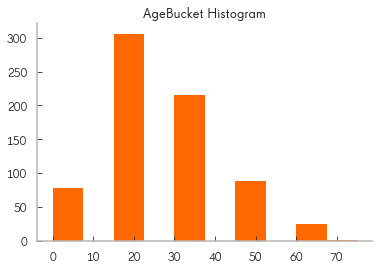

In [29]:
train_data['AgeBucket'].hist()
plt.title('AgeBucket Histogram');

In [34]:
# try lin regression model 
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg = cross_val_score(lin_reg, X_train, y_train, cv=10)
lin_reg.mean()

0.36251023334154475

In [35]:
# try log regression model 
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs')
log_reg = cross_val_score(log_reg, X_train, y_train, cv=10)
log_reg.mean()

/Users/cristian/miniconda3/envs/mlbook/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/cristian/miniconda3/envs/mlbook/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/cristian/miniconda3/envs/mlbook/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/cristian/miniconda3/envs/mlbook/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/cristian/miniconda3/envs/mlbook/lib/python3.5/site-packages/sklearn/linear_model/logistic

0.7980737146748382

# Try randomzed grid search 

In [36]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8149526160481217

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_clf = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(forest_clf, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2585e7f0>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a25560630>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [38]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.4355163866123252 {'max_features': 7, 'n_estimators': 180}
0.4494665749754947 {'max_features': 5, 'n_estimators': 15}
0.4393649125440716 {'max_features': 3, 'n_estimators': 72}
0.4431800195652587 {'max_features': 5, 'n_estimators': 21}
0.42902546629485455 {'max_features': 7, 'n_estimators': 122}
0.4393649125440716 {'max_features': 3, 'n_estimators': 75}
0.4393649125440716 {'max_features': 3, 'n_estimators': 88}
0.43293169680276444 {'max_features': 5, 'n_estimators': 100}
0.4380858271151806 {'max_features': 3, 'n_estimators': 150}
0.4519567135595372 {'max_features': 5, 'n_estimators': 2}


In [39]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.24599146, 0.04424947, 0.02796221, 0.24324536, 0.02543895,
       0.01417884, 0.06331295, 0.16386151, 0.13577624, 0.01149727,
       0.0073458 , 0.01713992])

In [40]:
trained_columns = num_attribs + cat_attribs
sorted(zip(feature_importances,trained_columns), reverse=True)

[(0.24599146108862616, 'Age'),
 (0.2432453642378827, 'Fare'),
 (0.16386151466597493, 'x1_female'),
 (0.1357762444372996, 'x1_male'),
 (0.06331294965164908, 'x0_3'),
 (0.044249473998742885, 'SibSp'),
 (0.027962214203230654, 'Parch'),
 (0.025438946753689153, 'x0_1'),
 (0.017139916449307638, 'x2_S'),
 (0.014178843638266206, 'x0_2'),
 (0.01149727185588034, 'x2_C'),
 (0.007345799019450544, 'x2_Q')]

# Try XGBOOST 

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

xgb_clf = GradientBoostingClassifier(random_state=42)
xgb_scores = cross_val_score(xgb_clf, X_train, y_train, cv=10)
xgb_scores.mean()

0.8306335830212234

In [42]:
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

rnd_search = RandomizedSearchCV(xgb_clf , param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2554bc50>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a25499128>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [43]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.14895335, 0.05463432, 0.0129287 , 0.17230701, 0.02848086,
       0.00322435, 0.09906191, 0.2538211 , 0.1993474 , 0.00633104,
       0.00949739, 0.01141258])

In [44]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.40893499959590224 {'max_features': 7, 'n_estimators': 180}
0.41708732973863794 {'max_features': 5, 'n_estimators': 15}
0.4277154618129319 {'max_features': 3, 'n_estimators': 72}
0.41438770700537403 {'max_features': 5, 'n_estimators': 21}
0.41573970964154905 {'max_features': 7, 'n_estimators': 122}
0.4277154618129319 {'max_features': 3, 'n_estimators': 75}
0.4250833416666831 {'max_features': 3, 'n_estimators': 88}
0.42902546629485455 {'max_features': 5, 'n_estimators': 100}
0.4237611507758188 {'max_features': 3, 'n_estimators': 150}
0.6058080281767212 {'max_features': 5, 'n_estimators': 2}


In [45]:
trained_columns = num_attribs + cat_attribs
sorted(zip(feature_importances,trained_columns), reverse=True)

[(0.25382110388010226, 'x1_female'),
 (0.19934740365512432, 'x1_male'),
 (0.172307007190922, 'Fare'),
 (0.14895334633855373, 'Age'),
 (0.09906190650614084, 'x0_3'),
 (0.054634316402261095, 'SibSp'),
 (0.028480859543780403, 'x0_1'),
 (0.012928697357699073, 'Parch'),
 (0.011412582895378507, 'x2_S'),
 (0.009497385342828416, 'x2_Q'),
 (0.006331040331581012, 'x2_C'),
 (0.0032243505556283354, 'x0_2')]

In [46]:
xgb_scores = cross_val_score(rnd_search.best_estimator_, X_train, y_train, cv=10)
xgb_scores.mean()

0.8339535807513336

# Try combining SibSp and Parch into one column 

In [47]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [48]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket,RelativesOnboard
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,15.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,15.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30.0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30.0,0


In [49]:
# add traveling alone
train_data['traveling_alone'] = np.where(train_data['RelativesOnboard']==0,1,0)

In [51]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket,RelativesOnboard,traveling_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,15.0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30.0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,15.0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30.0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30.0,0,1


# Train with new features 

In [145]:
from sklearn.compose import ColumnTransformer

cat_attribs = ["Pclass", "Sex",'Embarked',  'traveling_alone',  'AgeBucket']
num_attribs = [ "RelativesOnboard", "Fare"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train = full_pipeline.fit_transform(train_data)

In [146]:
# train model 
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

rnd_search = RandomizedSearchCV(xgb_clf , param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a259ebe10>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2593c128>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [147]:
# retrieve attribute names 
cat_attribs_encoded= list(full_pipeline.transformers_[1][1].named_steps["cat_encoder"].get_feature_names())
cat_attribs_encoded

['x0_1',
 'x0_2',
 'x0_3',
 'x1_female',
 'x1_male',
 'x2_C',
 'x2_Q',
 'x2_S',
 'x3_0',
 'x3_1',
 'x4_0.0',
 'x4_15.0',
 'x4_30.0',
 'x4_45.0',
 'x4_60.0',
 'x4_75.0']

In [148]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.08192006, 0.1699774 , 0.04586744, 0.0042519 , 0.09606122,
       0.31327154, 0.16540034, 0.00666192, 0.00525049, 0.01214963,
       0.00382754, 0.00313522, 0.05901834, 0.00736495, 0.01059647,
       0.0042138 , 0.00788706, 0.00314469])

In [149]:
trained_columns = num_attribs + cat_attribs_encoded
sorted(zip(feature_importances,trained_columns), reverse=True)

[(0.3132715440657515, 'x1_female'),
 (0.1699773996860322, 'Fare'),
 (0.16540034362597802, 'x1_male'),
 (0.09606121811357732, 'x0_3'),
 (0.08192005575154601, 'RelativesOnboard'),
 (0.05901833527662207, 'x4_0.0'),
 (0.04586743719495641, 'x0_1'),
 (0.01214963173962052, 'x2_S'),
 (0.010596470322577782, 'x4_30.0'),
 (0.007887059796208675, 'x4_60.0'),
 (0.007364953037001054, 'x4_15.0'),
 (0.006661920717302843, 'x2_C'),
 (0.0052504939470981804, 'x2_Q'),
 (0.00425189721088587, 'x0_2'),
 (0.004213796846597685, 'x4_45.0'),
 (0.0038275368285429177, 'x3_0'),
 (0.0031446857713303294, 'x4_75.0'),
 (0.003135220068370407, 'x3_1')]

In [150]:
xgb_scores = cross_val_score(rnd_search.best_estimator_, X_train, y_train, cv=10)
xgb_scores.mean()

0.8406701849960276

The model performs better without the age feature, but including AgeBucket as a category 

## Common strings in names

In [164]:
# split by coma, then by period for not survived 
train_data.loc[(train_data['Survived']==0)]['Name'].apply(lambda x: x.split(',')[1].split('.')[0]).apply(pd.Series).stack().value_counts()

 Mr          436
 Miss         55
 Mrs          26
 Master       17
 Rev           6
 Dr            4
 Don           1
 Jonkheer      1
 Major         1
 Capt          1
 Col           1
dtype: int64

In [165]:
# survived 
train_data.loc[(train_data['Survived']==1)]['Name'].apply(lambda x: x.split(',')[1].split('.')[0]).apply(pd.Series).stack().value_counts()

 Miss            127
 Mrs              99
 Mr               81
 Master           23
 Dr                3
 Mlle              2
 Sir               1
 the Countess      1
 Ms                1
 Major             1
 Lady              1
 Mme               1
 Col               1
dtype: int64

In [154]:
import re
train_data['Name'].apply(lambda x: re.compile(", (.*?).").findall(x))

0      []
1      []
2      []
3      []
4      []
5      []
6      []
7      []
8      []
9      []
10     []
11     []
12     []
13     []
14     []
15     []
16     []
17     []
18     []
19     []
20     []
21     []
22     []
23     []
24     []
25     []
26     []
27     []
28     []
29     []
       ..
861    []
862    []
863    []
864    []
865    []
866    []
867    []
868    []
869    []
870    []
871    []
872    []
873    []
874    []
875    []
876    []
877    []
878    []
879    []
880    []
881    []
882    []
883    []
884    []
885    []
886    []
887    []
888    []
889    []
890    []
Name: Name, Length: 891, dtype: object

In [131]:
train_data['Name_length']=train_data['Name'].apply(lambda x: len(x.split()))

In [106]:
# test name length, find mean for different survival outcomes
train_data.loc[train_data['Survived']==1][['Name_length']].mean()

Name_length    30.871345
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a258872b0>]],
      dtype=object)

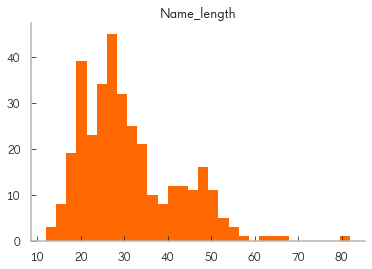

In [62]:
# visualize data 
train_data.loc[train_data['Survived']==1][['Name_length']].hist(bins=30)

In [64]:
train_data.loc[train_data['Survived']==0][['Name_length']].mean()

Name_length    24.531876
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a25900e10>]],
      dtype=object)

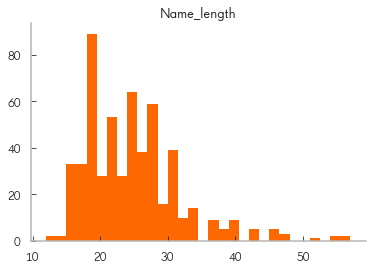

In [65]:
train_data.loc[train_data['Survived']==0][['Name_length']].hist(bins=30)

# Name length Category 

In [66]:
train_data['Name_length'] = train_data['Name'].apply(lambda x: 1 if len(x)>25 else 0)

In [67]:
train_data[['Survived', 'Name_length']]


,Survived,Name_length
0,0,0
1,1,1
2,1,0
3,1,1
4,0,0
5,0,0
6,0,0
7,0,1
8,1,1
9,1,1


# Add cabin feature 

In [100]:
# replaces nan with None
train_data['Cabin'] = np.where( pd.notnull(train_data['Cabin']), train_data['Cabin'],None)

In [102]:
train_data['Cabin'].describe()

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

In [132]:
train_data.tail(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket,RelativesOnboard,traveling_alone,Name_length
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S,45.0,2,0,6
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S,30.0,0,1,4
873,874,0,3,"Vander Cruyssen, Mr. Victor",male,47.0,0,0,345765,9.0000,None,S,45.0,0,1,4
874,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.0,1,0,P/PP 3381,24.0000,None,C,15.0,1,0,5
875,876,1,3,"Najib, Miss. Adele Kiamie ""Jane""",female,15.0,0,0,2667,7.2250,None,C,15.0,0,1,5
876,877,0,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.8458,None,S,15.0,0,1,4
877,878,0,3,"Petroff, Mr. Nedelio",male,19.0,0,0,349212,7.8958,None,S,15.0,0,1,3
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,None,S,NaN,0,1,3
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C,45.0,1,0,7
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,None,S,15.0,1,0,6
